In [3]:
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy.ma as ma
import cv2
from Engine.utils.inference import draw_text

def make_mosaic(images, num_rows, num_cols, border=1, class_names=None):
    num_images = len(images)
    image_shape = images.shape[1:]
    mosaic = ma.masked_all((num_rows * image_shape[0] + (num_rows - 1) * border,
                            num_cols * image_shape[1] + (num_cols - 1) * border),
                            dtype=np.float32)
    paddedh = image_shape[0] + border
    paddedw = image_shape[1] + border
    for image_arg in range(num_images):
        row = int(np.floor(image_arg / num_cols))
        col = image_arg % num_cols
        image = np.squeeze(images[image_arg])
        image_shape = image.shape
        mosaic[row * paddedh:row * paddedh + image_shape[0],
               col * paddedw:col * paddedw + image_shape[1]] = image
    return mosaic

def make_mosaic_v2(images, num_mosaic_rows=None,
                num_mosaic_cols=None, border=1):
    images = np.squeeze(images)
    num_images, image_pixels_rows, image_pixels_cols = images.shape
    if num_mosaic_rows is None and num_mosaic_cols is None:
        box_size = int(np.ceil(np.sqrt(num_images)))
        num_mosaic_rows = num_mosaic_cols = box_size
    num_mosaic_pixel_rows = num_mosaic_rows * (image_pixels_rows + border)
    num_mosaic_pixel_cols = num_mosaic_cols * (image_pixels_cols + border)
    mosaic = np.empty(shape=(num_mosaic_pixel_rows, num_mosaic_pixel_cols))
    mosaic_col_arg = 0
    mosaic_row_arg = 0
    for image_arg in range(num_images):
        if image_arg % num_mosaic_cols == 0 and image_arg != 0:
            mosaic_col_arg = mosaic_col_arg + 1
            mosaic_row_arg = 0
        x0 = image_pixels_cols * (mosaic_row_arg)
        x1 = image_pixels_cols * (mosaic_row_arg + 1)
        y0 = image_pixels_rows * (mosaic_col_arg)
        y1 = image_pixels_rows * (mosaic_col_arg + 1)
        image = images[image_arg]
        mosaic[y0:y1, x0:x1] = image
        mosaic_row_arg = mosaic_row_arg + 1
    return mosaic

def pretty_imshow(axis, data, vmin=None, vmax=None, cmap=None):
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    cax = None
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    image = axis.imshow(data, vmin=vmin, vmax=vmax,
                        interpolation='nearest', cmap=cmap)
    plt.colorbar(image, cax=cax)

def normal_imshow(axis, data, vmin=None, vmax=None,
                        cmap=None, axis_off=True):
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    image = axis.imshow(data, vmin=vmin, vmax=vmax,
                        interpolation='nearest', cmap=cmap)
    if axis_off:
        plt.axis('off')
    return image

def display_image(face, class_vector=None,
                    class_decoder=None, pretty=False):
    if class_vector is not None and class_decoder is None:
        raise Exception('Provide class decoder')
    face = np.squeeze(face)
    color_map = None
    if len(face.shape) < 3:
        color_map = 'gray'
    plt.figure()
    if class_vector is not None:
        class_arg = np.argmax(class_vector)
        class_name = class_decoder[class_arg]
        plt.title(class_name)
    if pretty:
        pretty_imshow(plt.gca(), face, cmap=color_map)
    else:
        plt.imshow(face, color_map)

def draw_mosaic(data, num_rows, num_cols, class_vectors=None,
                            class_decoder=None, cmap='gray'):

    if class_vectors is not None and class_decoder is None:
        raise Exception('Provide class decoder')

    figure, axis_array = plt.subplots(num_rows, num_cols)
    figure.set_size_inches(8, 8, forward=True)
    titles = []
    if class_vectors is not None:
        for vector_arg in range(len(class_vectors)):
            class_arg = np.argmax(class_vectors[vector_arg])
            class_name = class_decoder[class_arg]
            titles.append(class_name)

    image_arg = 0
    for row_arg in range(num_rows):
        for col_arg in range(num_cols):
            image = data[image_arg]
            image = np.squeeze(image)
            axis_array[row_arg, col_arg].axis('off')
            axis_array[row_arg, col_arg].imshow(image, cmap=cmap)
            axis_array[row_arg, col_arg].set_title(titles[image_arg])
            image_arg = image_arg + 1
    plt.tight_layout()

Using TensorFlow backend.


In [4]:
#from utils.data_manager import DataManager
from Engine.utils.datasets import get_labels
from keras.models import load_model
from Engine.utils.datasets import DataManager
import pickle

In [6]:
#dataset_name = 'fer2013'
#model_path = '../trained_models/emotion_models/simple_CNN.985-0.66.hdf5'
dataset_name = 'fer2013'
class_decoder = get_labels(dataset_name)
data_manager = DataManager(dataset_name)
faces, emotions = data_manager.get_data()
#faces = pickle.load(open('faces.pkl', 'rb'))
#emotions = pickle.load(open('emotions.pkl', 'rb'))
# pretty_imshow(plt.gca(), make_mosaic(faces[:4], 2, 2), cmap='gray')
# plt.show()

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import cv2
from keras.models import load_model

from Engine.utils.datasets import get_labels
from Engine.utils.inference import detect_faces
from Engine.utils.preprocessor import preprocess_input
from Engine.utils.video_transformation import trim_frame
from Engine.streaming_util.streaming_handler import create_new_streaming_file

def plot_convolution_matrix_of_model(emotion_model_path):
    
    class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    
    y_test_raw = emotions[:2000]
    x_test = faces[:2000]
    
    emotion_classifier = load_model(emotion_model_path, compile=False)
    
    # getting input model shapes for inference
    emotion_target_size = emotion_classifier.input_shape[1:3]
    
    y_pred = []
    y_test = []
    
    for i in range(len(y_test_raw)):
        gray_face = cv2.resize(x_test[i], (emotion_target_size))
        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        pred_label = np.argmax(emotion_prediction)
        
        # print("pred: "+str(emotion_prediction))
        
        index = int(list(y_test_raw[i]).index(1))
        y_test.append(class_names[index])
        y_pred.append(class_names[pred_label])
    
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            print("")
            # print('Confusion matrix, without normalization')
    
        # print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    plt.show()

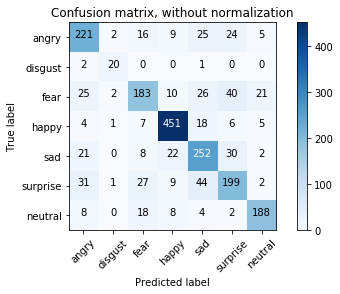

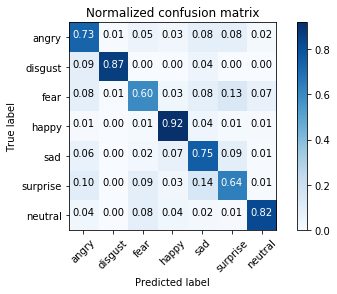

In [13]:
emotion_model_path = '/Users/danieltremer/Documents/GIT-Repositories/rage-analytics/Engine/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5'

plot_convolution_matrix_of_model(emotion_model_path)

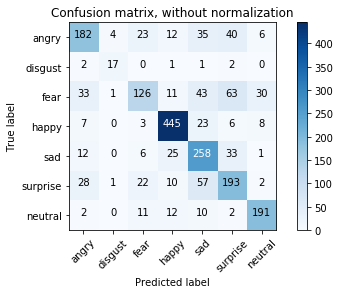

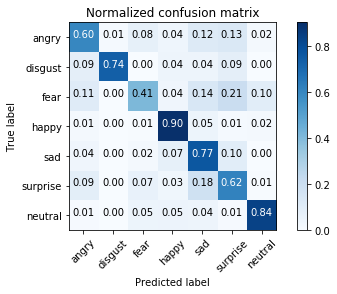

In [15]:
emotion_model_path = '/Users/danieltremer/Documents/GIT-Repositories/rage-analytics/Engine/trained_models/emotion_models/fer2013_simple_CNN.246-0.66.hdf5'

plot_convolution_matrix_of_model(emotion_model_path)